<a href="https://colab.research.google.com/github/rajashekar/colab/blob/main/ML_for_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This assignment is designed for automated pathology detection for Medical Images in a relalistic setup, i.e. each image may have multiple pathologies/disorders. 
### The goal, for you as an MLE, is to design models and methods to predictively detect pathological images and explain the pathology sites in the image data.

## Data for this assignment is taken from a Kaggle contest: https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview
Explanation of the data set:
The training data set contains 3435 retinal images that represent multiple pathological disorders. The patholgy classes and corresponding labels are: included in 'train.csv' file and each image can have more than one class category (multiple pathologies).
The labels for each image are

```
-opacity (0), 
-diabetic retinopathy (1), 
-glaucoma (2),
-macular edema (3),
-macular degeneration (4),
-retinal vascular occlusion (5)
-normal (6)
```
The test data set contains 350 unlabelled images.

# For this assignment, you are working with specialists for Diabetic Retinopathy and Glaucoma only, and your client is interested in a predictive learning model along with feature explanability and self-learning for Diabetic Retinopathy and Glaucoma vs. Normal images.
# Design models and methods for the following tasks. Each task should be accompanied by code, plots/images (if applicable), tables (if applicable) and text:
## Task 1: Build a classification model for Diabetic Retinopathy and Glaucoma vs normal images. You may consider multi-class classification vs. all-vs-one classification. Clearly state your choice and share details of your model, paremeters and hyper-paramaterization pprocess. (60 points)
```
a. Perform 70/30 data split and report performance scores on the test data set.
b. You can choose to apply any data augmentation strategy. 
Explain your methods and rationale behind parameter selection.
c. Show Training-validation curves to ensure overfitting and underfitting is avoided.
```
## Task 2: Visualize the heatmap/saliency/features using any method of your choice to demonstrate what regions of interest contribute to Diabetic Retinopathy and Glaucoma, respectively. (25 points)
```
Submit images/folder of images with heatmaps/features aligned on top of the images, or corresponding bounding boxes, and report what regions of interest in your opinion represent the pathological sites.
```

## Task 3: Using the unlabelled data set in the 'test' folder augment the training data (semi-supervised learning) and report the variation in classification performance on test data set.(15 points)
[You may use any method of your choice, one possible way is mentioned below.] 

```
Hint: 
a. Train a model using the 'train' split.
b. Pass the unlabelled images through the trained model and retrieve the dense layer feature prior to classification layer. Using this dense layer as representative of the image, apply label propagation to retrieve labels correspndng to the unbalelled data.
c. Next, concatenate the train data with the unlabelled data (that has now been self labelled) and retrain the network.
d. Report classification performance on test data
Use the unlabelled test data  to improve classification performance by using a semi-supervised label-propagation/self-labelling approach. (20 points)
```

## [Hint: If you are wondering how to use the "dense layer representative of an image" in step 2, see this exercise that extracts a [1,2048] dense representattive from an image using the InceptionV3 pre-trained model.]
https://colab.research.google.com/drive/14-6qRGARgBSj4isZk86zKQtyIT2f9Wu1#scrollTo=_IqraxtP4Ex3


## Good Luck!

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Colab/Fourth.Brain/ML.for.Computer.Vision/

/content/gdrive/MyDrive/Colab/Fourth.Brain/ML.for.Computer.Vision


In [3]:
%ls

Data.zip  ML_for_Computer_Vision.ipynb


In [ ]:
!unzip Data.zip

In [9]:
!head -2 Data/train/train.csv

filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
c24a1b14d253.jpg,0,0,0,0,0,1,0


In [131]:
import os 

import numpy as np
import pandas as pd

from PIL import Image

from sklearn.model_selection import train_test_split

import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

from fastprogress import master_bar, progress_bar

In [15]:
data = pd.read_csv("Data/train/train.csv")
data.head()

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0


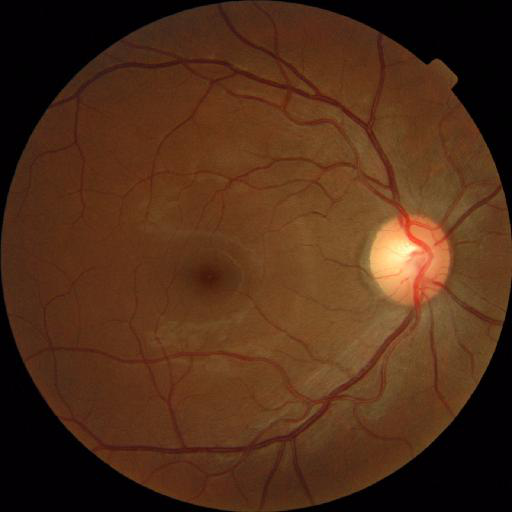

In [75]:
# check one normal retina image
Image.open(f"Data/train/train/{data.loc[data['normal'] == 1].iloc[0]['filename']}")

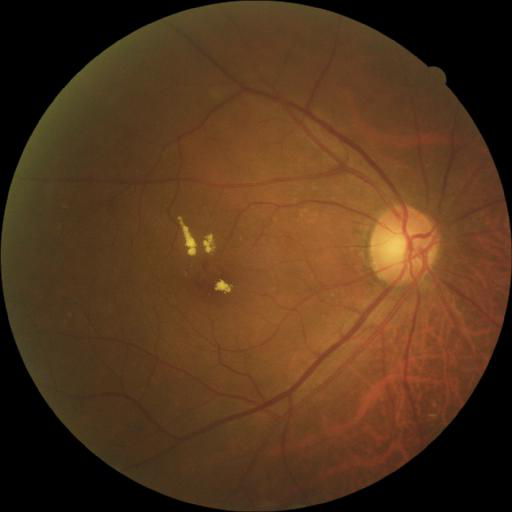

In [76]:
Image.open(f"Data/train/train/{data.loc[data['diabetic retinopathy'] == 1].iloc[0]['filename']}")

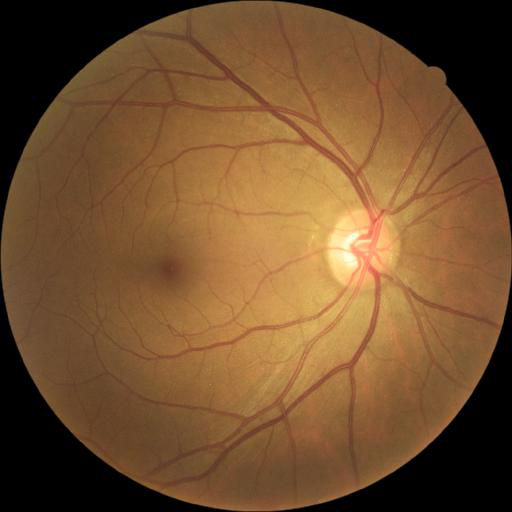

In [78]:
# check glaucoma
Image.open(f"Data/train/train/{data.loc[data['glaucoma'] == 1].iloc[0]['filename']}")

In [44]:
# Distribution - normal vs diabetic retinopathy vs glaucoma
print(data['normal'].value_counts())
print(data['diabetic retinopathy'].value_counts())
print(data['glaucoma'].value_counts())

0    2910
1     525
Name: normal, dtype: int64
0    2680
1     755
Name: diabetic retinopathy, dtype: int64
0    2838
1     597
Name: glaucoma, dtype: int64


In [58]:
#get data of normal vs diabetic retinopathy vs glaucoma
final_data = data[['filename','normal','diabetic retinopathy','glaucoma']]

In [59]:
final_data.head()

,filename,normal,diabetic retinopathy,glaucoma
0,c24a1b14d253.jpg,0,0,0
1,9ee905a41651.jpg,0,0,0
2,3f58d128caf6.jpg,0,0,1
3,4ce6599e7b20.jpg,0,0,0
4,0def470360e4.jpg,0,0,0


## Preparing the dataset

In [93]:
# Perform 70/30 data split
train_data, val_data = train_test_split(final_data, test_size=0.3, random_state=42)

In [94]:
print(f"Full Data size - {len(final_data)}")
print(f"Train Data size - {len(train_data)}")
print(f"Validation Data size - {len(val_data)}")

Full Data size - 3435
Train Data size - 2404
Validation Data size - 1031


For using Incepction_v3 - https://pytorch.org/hub/pytorch_vision_inception_v3/ <br>
All pre-trained models expect input images normalized in the same way, <br>
 i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 299. <br>
The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [95]:
class RetinaDataset(Dataset):
  def __init__(self, img_dir, dataframe, image_size, normalize):
    self.image_paths = [] 
    self.image_labels = []
    image_transformation = [
      transforms.Resize((image_size, image_size)),
      transforms.ToTensor()
    ]
    if normalize:
      # Mean and Standard deviation values from ImageNet
      image_transformation.append(transforms.Normalize([0.485, 0.456, 0.406] , [0.229, 0.224, 0.225]))
    self.image_transformation = transforms.Compose(image_transformation)

    for index, row in dataframe.iterrows():
      image_path = os.path.join(img_dir, row.filename)
      self.image_paths.append(image_path)
      self.image_labels.append(row[1:])

  def __len__(self):  
    return len(self.image_paths)

  def __getitem__(self, index):
    image_path = self.image_paths[index]
    image_data = Image.open(image_path).convert("RGB")
    image_data = self.image_transformation(image_data)
    return image_data, torch.FloatTensor(self.image_labels[index])

In [103]:
# create train dataset
train_ds = RetinaDataset("Data/train/train", train_data, 299, True)
# create validation dataset
val_ds = RetinaDataset("Data/train/train", val_data, 299, True)

In [104]:
BATCH_SIZE = 32
# Data loaders
train_dataloader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(dataset=val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

In [111]:
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
print(f"image size {images.size()}")
print(f"labels size {labels.size()}")

image size torch.Size([32, 3, 299, 299])
labels size torch.Size([32, 3])


Above shows we have <br>
Image tensor have 32 batches, 3 channels, image H x W - 299 <br>
Label tensor have 32 batches, 3 classes

## Model definition

In [116]:
# checking how inception v3 net is constructed
m = torchvision.models.inception_v3(pretrained=True)
m

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [125]:
class InceptionNet(nn.Module):
  def __init__(self, num_classes, is_trained=True):
    super().__init__()
    self.net = torchvision.models.inception_v3(pretrained=is_trained)

    linear_in_features = self.net.fc.in_features
    # inception linear layer has 2048 in features and out is 1000 classes
    # so replace that with 3 classes which we will be sending as param
    self.net.fc = nn.Sequential(nn.Linear(linear_in_features, num_classes), nn.Sigmoid())

  def forward(self, inputs):
    return self.net(inputs)

In [120]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [123]:
LABELS = final_data.columns[1:]
LABELS

Index(['normal', 'diabetic retinopathy', 'glaucoma'], dtype='object')

In [126]:
model = InceptionNet(num_classes=len(LABELS))
model.to(device)
model

InceptionNet(
  (net): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicC

In [127]:
# Total number parameters in the network to train
sum(p.numel() for p in model.parameters() if p.requires_grad)

25118411

Above came to 25 million parameters

## Training

In [133]:
lr = 0.001

# loss function
loss_criteria = nn.BCELoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)

In [136]:
best_score = 0
model_path = "inception.pth"
training_losses = []
validation_losses = []
validation_score = []

epochs = 2
x = []


mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss', 'Validation F1 Score']

for epoch in mb:
  mb.main_bar.comment = f'Best F1 score: {best_score}'
  x.append(epoch)

  #############
  # TRAINING
  #############
  # put model in train mode
  model.train()
  training_loss = 0
  for batch, (images, labels) in enumerate(progress_bar(train_dataloader, parent=mb)):
    # move to GPU
    images = images.to(device)
    labels = labels.to(device)

    # clear previous gradients
    optimizer.zero_grad()

    # Feed forward the model
    pred = model(images)
    loss = loss_criteria(pred.logits, labels)

    # back propagation
    loss.backward()

    # update parameters
    optimizer.step()
    training_loss += loss.item()

    mb.child.comment = f'Training loss {training_loss/(batch+1)}'

  # clear memory
  del images, labels, loss
  if torch.cuda.is_available(): torch.cuda.empty_cache()

  train_loss = training_loss/len(train_dataloader)
  mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
  training_losses.append(train_loss)

  #############
  # Evaluate
  #############
  # put model in eval mode
  model.eval()
  val_loss = 0
  out_pred = torch.FloatTensor().to(device)
  out_actual = torch.FloatTensor().to(device)

  with torch.no_grad(): # Turn off gradient
    for batch, (images, labels) in enumerate(progress_bar(val_loader, parent=mb)):
      # move to GPU
      images = images.to(device)
      labels = labels.to(device)

      # update with actual labels
      out_actual = torch.cat((out_actual,  labels), 0)

      # feed forward model
      pred = model(images)
      loss = loss_criteria(pred.logits, labels)

      # Update prediction values
      out_pred = torch.cat((out_pred, pred), 0)
      val_loss += loss
      mb.child.comment = f'Validation loss {val_loss/(batch+1)}'

  # clear memory
  del images, labels, loss
  if torch.cuda.is_available(): torch.cuda.empty_cache()

  val_loss= val_loss/len(val_loader), 
  new_score = np.array(multi_label_f1(out_gt, out_pred)).mean()

  validation_losses.append(val_loss)
  validation_score.append(new_score)

  mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score]], [0,epochs], [0,1])

  # Save model
  if best_score < new_score:
    mb.write(f"Improved F1 from {best_score} to {new_score}")
    best_score = new_score
    torch.save(model.state_dict(), model_path)

KeyboardInterrupt: ignored